# Loading dataset and neccessary packages

In [ ]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Download NLTK data
nltk.download('punkt')
nltk.download("punkt_tab")
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#Load Banking77 dataset
ds = load_dataset("banking77")
train_df = ds["train"].to_pandas()
test_df  = ds["test"].to_pandas()
print(f"✓ Dataset loaded successfully")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/298k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/93.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

✓ Dataset loaded successfully


### Preprocessing and Feature Engineering

In [ ]:
# Check missing values in train and test
print("Training data missing values:\n", train_df.isnull().sum())
print("\nTesting data missing values:\n", test_df.isnull().sum())

print(f"\nTotal samples in train: {len(train_df)}, test: {len(test_df)}")

Training data missing values:
 text     0
label    0
dtype: int64

Testing data missing values:
 text     0
label    0
dtype: int64

Total samples in train: 10003, test: 3080


In [ ]:
# Check label column types
print(train_df['label'].apply(type).value_counts())
print(test_df['label'].apply(type).value_counts())

label
<class 'int'>    10003
Name: count, dtype: int64
label
<class 'int'>    3080
Name: count, dtype: int64


In [ ]:
# Map numeric labels to readable intent names
label_names = ds["train"].features["label"].names
train_df["label_text"] = train_df["label"].apply(lambda i: label_names[i])
test_df["label_text"]  = test_df["label"].apply(lambda i: label_names[i])

#Intent names stored in the dataset itself (ClassLabel) and ensures consistency between numbers and intent names.

In [ ]:
train_df['split'] = 'train'
test_df['split']  = 'test'
full_data = pd.concat([train_df, test_df], ignore_index=True)
print(f"  - Total samples: {len(full_data)}")

  - Total samples: 13083


In [ ]:
# Show 5 random rows from the full dataset
full_data.sample(5, random_state=42)

,text,label,label_text,split
353,Please explain the exchange rates.,32,exchange_rate,train
10210,I got some cash of an ATM earlier but this sho...,46,pending_cash_withdrawal,test
5361,I just replaced my phone but how do I use my c...,42,lost_or_stolen_phone,train
7051,I wasn't able to do a transfer to an account,7,beneficiary_not_allowed,train
3617,I don't recognize a charge on my statement.,16,card_payment_not_recognised,train


In [ ]:
print(0, "→", label_names[0])   # first class
print(76, "→", label_names[76]) # last class

0 → activate_my_card
76 → wrong_exchange_rate_for_cash_withdrawal


In [ ]:
# All rows where label == 75
label75_rows = train_df[train_df["label"] == 75]

# Show first 75 examples
print(label75_rows.head())


                                                   text  label  \
2331  Why did I only receive a partial amount of wha...     75   
2332                       my atm transaction was wrong     75   
2333                           why did i only get 20.00     75   
2334  Why is my cash request and the amount I receiv...     75   
2335  I tried to withdraw $100, all it gave me was $20.     75   

                         label_text  split  
2331  wrong_amount_of_cash_received  train  
2332  wrong_amount_of_cash_received  train  
2333  wrong_amount_of_cash_received  train  
2334  wrong_amount_of_cash_received  train  
2335  wrong_amount_of_cash_received  train  


In [ ]:
# All rows where label == 76
label76_rows = train_df[train_df["label"] == 76]

# Show first 5 examples
print(label76_rows.head())

                                                   text  label  \
8208  The wrong exchange rate was applied to me whil...     76   
8209      I got less cash because of the exchange rate.     76   
8210  Why is the fee for taking money out so high?  ...     76   
8211  I believe a wrong exchange rate was applied to...     76   
8212  When I got my cash, the amount was not what it...     76   

                                   label_text  split  
8208  wrong_exchange_rate_for_cash_withdrawal  train  
8209  wrong_exchange_rate_for_cash_withdrawal  train  
8210  wrong_exchange_rate_for_cash_withdrawal  train  
8211  wrong_exchange_rate_for_cash_withdrawal  train  
8212  wrong_exchange_rate_for_cash_withdrawal  train  


In [ ]:
# All rows where label == 70
label70_rows = train_df[train_df["label"] == 70]

# Show first 5 examples
print(label70_rows.head())

                                                   text  label  \
6481                 where exactly does money come from     70   
6482                      Where did my money come from?     70   
6483      Can I check to see where the funds came from?     70   
6484  What are the sources for the funds in my account?     70   
6485                need to know where money comes from     70   

                  label_text  split  
6481  verify_source_of_funds  train  
6482  verify_source_of_funds  train  
6483  verify_source_of_funds  train  
6484  verify_source_of_funds  train  
6485  verify_source_of_funds  train  


In [ ]:
# All rows where label == 21
label21_rows = train_df[train_df["label"] == 21]

# Show first 5 examples
print(label21_rows.head())

                                                   text  label  label_text  \
6883     Is it possible for me to change my PIN number?     21  change_pin   
6884  What are the steps to change my PIN to somethi...     21  change_pin   
6885  In what way can I change my PIN and where do I...     21  change_pin   
6886          Can I change my PIN at any cash machines?     21  change_pin   
6887      I need to make my card PIN a different number     21  change_pin   

      split  
6883  train  
6884  train  
6885  train  
6886  train  
6887  train  


In [ ]:
# All rows where label == 52
label52_rows = train_df[train_df["label"] == 52]

# Show first 5 examples
print(label52_rows.head())

                                                   text  label  \
5372  How long does it take to get a refund on somet...     52   
5373  Please tell me how to get a refund for somethi...     52   
5374                        Can i cancel this purchase?     52   
5375  I want to return an item for a refund can I do...     52   
5376                             Can I request a refund     52   

          label_text  split  
5372  request_refund  train  
5373  request_refund  train  
5374  request_refund  train  
5375  request_refund  train  
5376  request_refund  train  


In [ ]:
# All rows where label == 50
label50_rows = train_df[train_df["label"] == 50]

# Show first 5 examples
print(label50_rows.head())

                                                   text  label  \
7333                    Can my salary be received here?     50   
7334       How can my boss pay me directly to the card?     50   
7335  Salary in GBP has been received. Does it need ...     50   
7336  I am paid by my employer in GBP; do I need to ...     50   
7337                   How can my friend give me money?     50   

           label_text  split  
7333  receiving_money  train  
7334  receiving_money  train  
7335  receiving_money  train  
7336  receiving_money  train  
7337  receiving_money  train  


In [ ]:
# All rows where label == 20
label20_rows = train_df[train_df["label"] == 20]

# Show first 5 examples
print(label20_rows.head())

                                                   text  label  \
8784  I looked on the app and it says I withdrew cas...     20   
8785  I didn't withdraw the amount of cash that is s...     20   
8786  I saw on the app that a cash withdrawal was co...     20   
8787  I got a notice from my app that I withdrew cas...     20   
8788  Someone has a copy of my card !! I definitely ...     20   

                          label_text  split  
8784  cash_withdrawal_not_recognised  train  
8785  cash_withdrawal_not_recognised  train  
8786  cash_withdrawal_not_recognised  train  
8787  cash_withdrawal_not_recognised  train  
8788  cash_withdrawal_not_recognised  train  


In [ ]:
# All rows where label == 56
label56_rows = train_df[train_df["label"] == 56]

# Show first 5 examples
print(label56_rows.head())

                                                   text  label  \
1817                Is there a top up fee for transfer?     56   
1818  Will there be a charge for topping up by accou...     56   
1819  What are the charges for receiving a SEPA tran...     56   
1820              Is there a charge for SEPA transfers?     56   
1821       Will I be charged a fee for a SEPA transfer?     56   

                          label_text  split  
1817  top_up_by_bank_transfer_charge  train  
1818  top_up_by_bank_transfer_charge  train  
1819  top_up_by_bank_transfer_charge  train  
1820  top_up_by_bank_transfer_charge  train  
1821  top_up_by_bank_transfer_charge  train  


In [ ]:
# All rows where label == 42
label42_rows = train_df[train_df["label"] == 42]

# Show first 42 examples
print(label42_rows.head())

                                                   text  label  \
5251       My phone was stolen, what should I do first?     42   
5252             My phone was stolen, what should I do?     42   
5253                 I lost my phone, what should I do?     42   
5254     Someone has stolen my phone, what should I do?     42   
5255  I think I lost my phone.  Is there a way to pr...     42   

                label_text  split  
5251  lost_or_stolen_phone  train  
5252  lost_or_stolen_phone  train  
5253  lost_or_stolen_phone  train  
5254  lost_or_stolen_phone  train  
5255  lost_or_stolen_phone  train  


In [ ]:
#check the label and names
for i, name in enumerate(label_names):
    print(i, "→", name)

0 → activate_my_card
1 → age_limit
2 → apple_pay_or_google_pay
3 → atm_support
4 → automatic_top_up
5 → balance_not_updated_after_bank_transfer
6 → balance_not_updated_after_cheque_or_cash_deposit
7 → beneficiary_not_allowed
8 → cancel_transfer
9 → card_about_to_expire
10 → card_acceptance
11 → card_arrival
12 → card_delivery_estimate
13 → card_linking
14 → card_not_working
15 → card_payment_fee_charged
16 → card_payment_not_recognised
17 → card_payment_wrong_exchange_rate
18 → card_swallowed
19 → cash_withdrawal_charge
20 → cash_withdrawal_not_recognised
21 → change_pin
22 → compromised_card
23 → contactless_not_working
24 → country_support
25 → declined_card_payment
26 → declined_cash_withdrawal
27 → declined_transfer
28 → direct_debit_payment_not_recognised
29 → disposable_card_limits
30 → edit_personal_details
31 → exchange_charge
32 → exchange_rate
33 → exchange_via_app
34 → extra_charge_on_statement
35 → failed_transfer
36 → fiat_currency_support
37 → get_disposable_virtual_card


In [ ]:
# Add hierarchical categories

hierarchical_categories_rules = [
    ("Card Services",      ["card", "chargeback", "contactless","cash_withdrawal","passcode","wrong_amount_of_cash_received","lost_or_stolen_card"]),
    ("Transfer & Payments",["transfer", "transaction", "payment", "direct_debit", "standing_order", "bank_transfer", "international","pay","exchange","refund","top_up","beneficiary_not_allowed","verify_source_of_funds","receiving_money"]),
    ("Account Management", ["account", "statement", "address", "login","pin", "verification", "id", "name", "close_account", "upgrade","deposit","personal_details"]),
    ("General Support",    ["support", "atm", "branch", "age_limit", "app", "country_support", "fees", "troubleshooting","currency_support","lost_or_stolen_phone","verify_identity","verify_my_identity"]),
]


# Map label_text to category using keywords
def map_category(intent_name):
    intent_name_lower = str(intent_name).lower()
    for category, keywords in hierarchical_categories_rules:
        if any(kw in intent_name_lower for kw in keywords):
            return category
    return "General Support"

# Apply mapping using label_text
full_data['category'] = full_data['label_text'].apply(map_category)

# Show 5 random rows for check the dataset
full_data.sample(5, random_state=42)

,text,label,label_text,split,category
353,Please explain the exchange rates.,32,exchange_rate,train,Transfer & Payments
10210,I got some cash of an ATM earlier but this sho...,46,pending_cash_withdrawal,test,Card Services
5361,I just replaced my phone but how do I use my c...,42,lost_or_stolen_phone,train,General Support
7051,I wasn't able to do a transfer to an account,7,beneficiary_not_allowed,train,Transfer & Payments
3617,I don't recognize a charge on my statement.,16,card_payment_not_recognised,train,Card Services


In [ ]:
# Add urgency labels

CRITICAL_KW = [
    "stolen", "lost", "fraud", "scam", "unauthorized", "blocked",
    "freeze", "locked", "declined", "suspicious", "hacked",
    "compromised", "security", "urgent", "emergency" , 'stolen', 'fraud', 'fraudulent',
    "emergency", "urgent", "immediately", "asap", "locked out",
    "frozen", "suspended", "missing money", "wrong charge", "double charged",
    "cant access", "help", "stuck", "error","unable", "extra charge"
]

LOW_KW = [
    "how do i", "how to", "what is", "info", "information", "where is",
    "when is", "tell me", "learn", "guide", "help with", "can i",
    "is it possible", "fees", "limits"
]

def label_urgency_3class(text, label_text):
    combined = f"{str(text)} {str(label_text)}".lower()

    # Check for critical first  highest priority
    if any(k in combined for k in CRITICAL_KW):
        return "Critical"

    # Then check for low urgency
    if any(k in combined for k in LOW_KW):
        return "Low"

    # If ends with ? and no keywords detected  Low
    if text.strip().endswith("?"):
        return "Low"

    # Everything else  Normal
    return "Normal"

# Apply to dataset
full_data['urgency'] = full_data.apply(
    lambda row: label_urgency_3class(row['text'], row['label_text']), axis=1
)

# check the count for all 3 urgency categories
print(full_data['urgency'].value_counts())

urgency
Low         7425
Normal      3533
Critical    2125
Name: count, dtype: int64


In [ ]:
full_data.sample(5, random_state=42)

,text,label,label_text,split,category,urgency
353,Please explain the exchange rates.,32,exchange_rate,train,Transfer & Payments,Normal
10210,I got some cash of an ATM earlier but this sho...,46,pending_cash_withdrawal,test,Card Services,Low
5361,I just replaced my phone but how do I use my c...,42,lost_or_stolen_phone,train,General Support,Critical
7051,I wasn't able to do a transfer to an account,7,beneficiary_not_allowed,train,Transfer & Payments,Normal
3617,I don't recognize a charge on my statement.,16,card_payment_not_recognised,train,Card Services,Normal


In [ ]:
# Print only the text of that row to check
print(full_data.loc[5361, "text"])

I just replaced my phone but how do I use my card information?


In [ ]:
# Text cleaning with NLTK
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()                       # Lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)        # Remove punctuation
    tokens = word_tokenize(text)                   # Tokenize
    tokens = [t for t in tokens if t not in stop_words]  # Remove stopwords
    return " ".join(tokens)

# Apply to the combined dataset
full_data['clean_text'] = full_data['text'].apply(clean_text)

# Quick check
print(full_data[['text', 'clean_text']].head())
full_data.sample(5, random_state=42)


                                                text  \
0                     I am still waiting on my card?   
1  What can I do if my card still hasn't arrived ...   
2  I have been waiting over a week. Is the card s...   
3  Can I track my card while it is in the process...   
4  How do I know if I will get my card, or if it ...   

                         clean_text  
0                still waiting card  
1  card still hasnt arrived 2 weeks  
2    waiting week card still coming  
3       track card process delivery  
4                know get card lost  


,text,label,label_text,split,category,urgency,clean_text
353,Please explain the exchange rates.,32,exchange_rate,train,Transfer & Payments,Normal,please explain exchange rates
10210,I got some cash of an ATM earlier but this sho...,46,pending_cash_withdrawal,test,Card Services,Low,got cash atm earlier shows pending app still p...
5361,I just replaced my phone but how do I use my c...,42,lost_or_stolen_phone,train,General Support,Critical,replaced phone use card information
7051,I wasn't able to do a transfer to an account,7,beneficiary_not_allowed,train,Transfer & Payments,Normal,wasnt able transfer account
3617,I don't recognize a charge on my statement.,16,card_payment_not_recognised,train,Card Services,Normal,dont recognize charge statement


In [ ]:
# Extract category names from the list of tuples
category_names = [item[0] for item in hierarchical_categories_rules]

# Create numeric mapping
category_mapping = {category: idx for idx, category in enumerate(category_names)}

# Apply mapping to full_data
full_data['category_label'] = full_data['category'].map(category_mapping)

# Urgency mapping stays the same
urgency_mapping = {'Critical': 0, 'Normal': 1, 'Low': 2}
full_data['urgency_label'] = full_data['urgency'].map(urgency_mapping)

# Check
print("Category mapping:", category_mapping)
print("Urgency mapping:", urgency_mapping)


Category mapping: {'Card Services': 0, 'Transfer & Payments': 1, 'Account Management': 2, 'General Support': 3}
Urgency mapping: {'Critical': 0, 'Normal': 1, 'Low': 2}


# Exploratory Data Analysis

In [ ]:
#check the overview of preprocessed dataset

def describe_full_df(df, name="Full Dataset"):
    print(f"\n{name} overview:")
    print("Total examples:", len(df))
    print("Unique intents:", df['label_text'].nunique())
    print("Unique categories:", df['category'].nunique())
    print("Unique urgency levels:", df['urgency'].nunique())

    print("\nTop 5 intents:\n", df['label_text'].value_counts().head())
    print("\nCategory distribution:\n", df['category'].value_counts())
    print("\nUrgency distribution:\n", df['urgency'].value_counts())

# Call it on your combined dataset
describe_full_df(full_data, "Full Dataset")



Full Dataset overview:
Total examples: 13083
Unique intents: 77
Unique categories: 4
Unique urgency levels: 3

Top 5 intents:
 label_text
card_payment_fee_charged                            227
direct_debit_payment_not_recognised                 222
balance_not_updated_after_cheque_or_cash_deposit    221
wrong_amount_of_cash_received                       220
cash_withdrawal_charge                              217
Name: count, dtype: int64

Category distribution:
 category
Card Services          5816
Transfer & Payments    4994
Account Management     1500
General Support         773
Name: count, dtype: int64

Urgency distribution:
 urgency
Low         7425
Normal      3533
Critical    2125
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

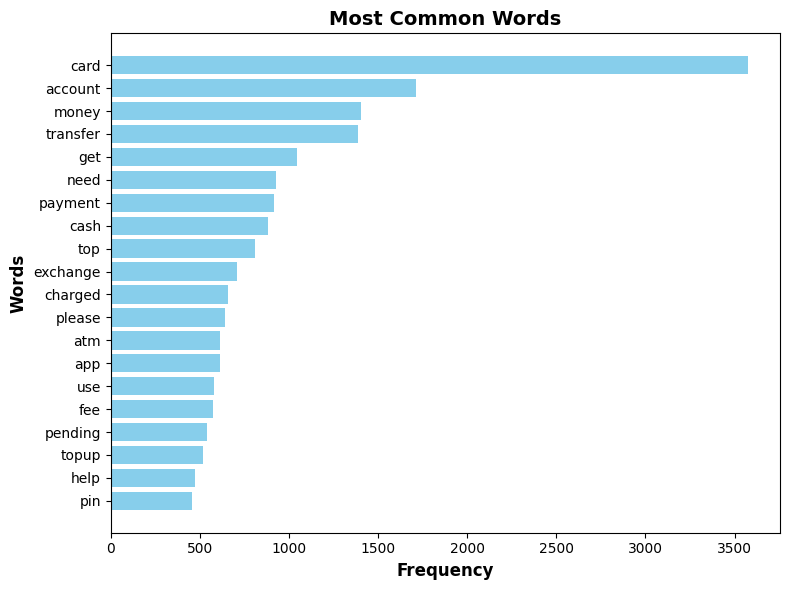

In [ ]:
#Frequent words Analysis

from collections import Counter
import matplotlib.pyplot as plt

# Get all words from clean_text
all_words = ' '.join(full_data['clean_text']).split()

# Count frequencies
word_freq = Counter(all_words)
top_words = dict(word_freq.most_common(20))

# Plot
plt.figure(figsize=(8,6))
plt.barh(range(len(top_words)), list(top_words.values()), color='skyblue')
plt.yticks(range(len(top_words)), list(top_words.keys()), fontsize=10)
plt.gca().invert_yaxis()  # largest on top
plt.title('Most Common Words', fontsize=14, fontweight='bold')
plt.xlabel('Frequency', fontsize=12, fontweight='bold')
plt.ylabel('Words', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

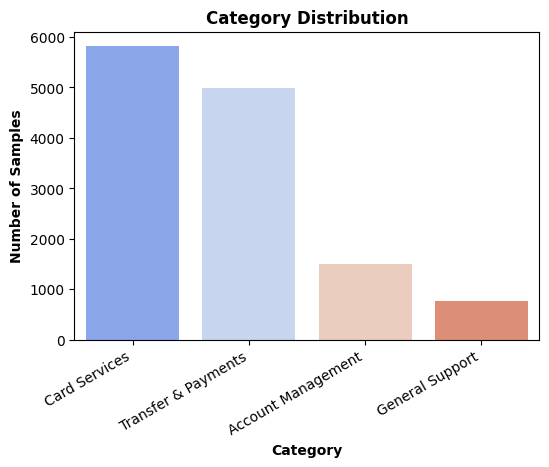

In [ ]:
#visualize category distribution

#count values
category_counts=full_data['category'].value_counts()

#Bar plot

plt.figure(figsize=(6,4))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="coolwarm")
plt.title("Category Distribution",fontweight="bold")
plt.xlabel("Category", fontweight="bold")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Number of Samples", fontweight="bold")
plt.show()

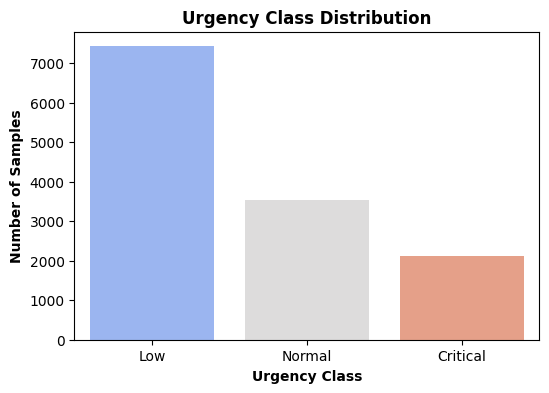

In [ ]:
#visualization of urgency distribution

# Count values
urgency_counts = full_data['urgency'].value_counts()

# Bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=urgency_counts.index, y=urgency_counts.values, palette="coolwarm")
plt.title("Urgency Class Distribution", fontweight="bold")
plt.xlabel("Urgency Class",fontweight="bold")
plt.ylabel("Number of Samples",fontweight="bold")
plt.show()


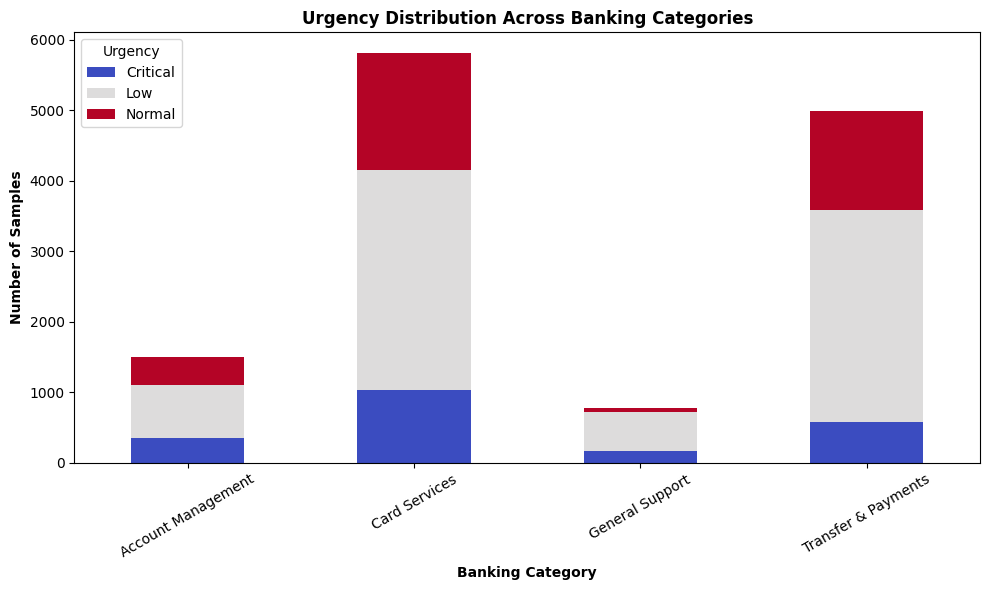

In [ ]:
#visualize the distribution of urgency within each hierarchical category

# Count samples for each category & urgency
category_urgency_counts = full_data.groupby(['category', 'urgency']).size().unstack(fill_value=0)

# Plot stacked bar chart
category_urgency_counts.plot(kind='bar', stacked=True, figsize=(10,6), colormap='coolwarm')
plt.title("Urgency Distribution Across Banking Categories",fontweight="bold")
plt.xlabel("Banking Category",fontweight="bold")
plt.ylabel("Number of Samples",fontweight="bold")
plt.xticks(rotation=30)
plt.legend(title="Urgency")
plt.tight_layout()
plt.show()


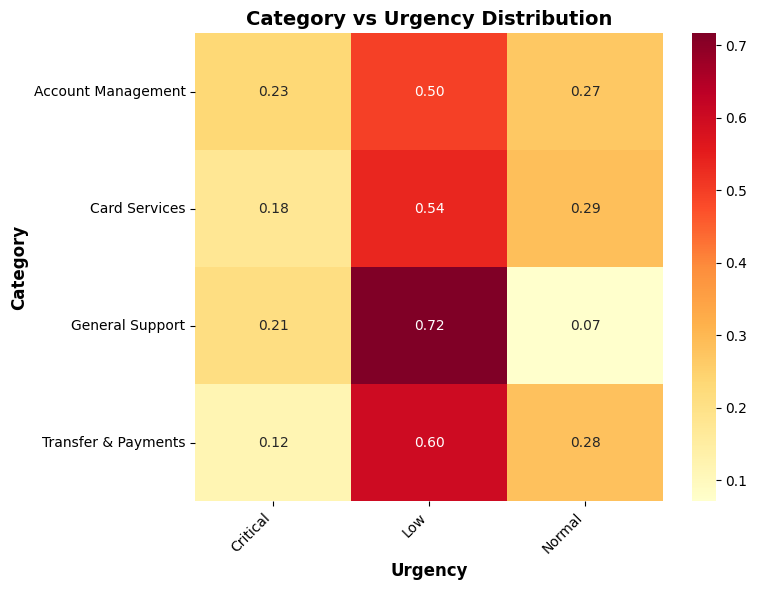

In [ ]:
#Category vs Urgency Heatmap (Full Data)
plt.figure(figsize=(8,6))
category_urgency = pd.crosstab(full_data['category'], full_data['urgency'], normalize='index')

sns.heatmap(category_urgency, annot=True, fmt='.2f', cmap='YlOrRd')

plt.title('Category vs Urgency Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Urgency', fontsize=12, fontweight='bold')
plt.ylabel('Category', fontsize=12, fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Full data text length stats (words): min 2 max 79 mean 11.71 median 10


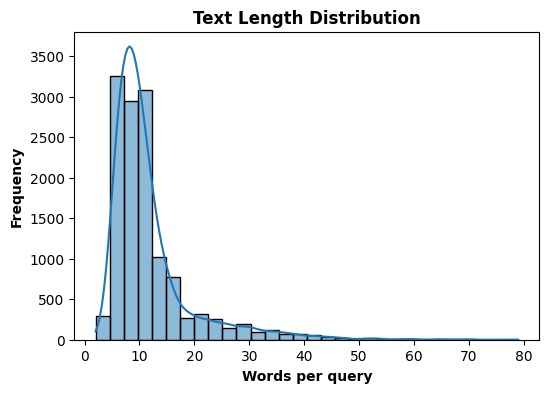

In [ ]:
# Text length analysis (Full Data)
full_lengths = full_data['text'].apply(lambda s: len(s.split()))
print("Full data text length stats (words):",
      "min", full_lengths.min(),
      "max", full_lengths.max(),
      "mean", round(full_lengths.mean(), 2),
      "median", int(full_lengths.median()))

plt.figure(figsize=(6,4))
sns.histplot(full_lengths, bins=30, kde=True)  # added kde for smoother curve
plt.title('Text Length Distribution', fontweight="bold")
plt.xlabel('Words per query', fontweight="bold")
plt.ylabel('Frequency', fontweight="bold")
plt.show()


Full data text length stats (words): min 1 max 47 mean 5.31 median 4


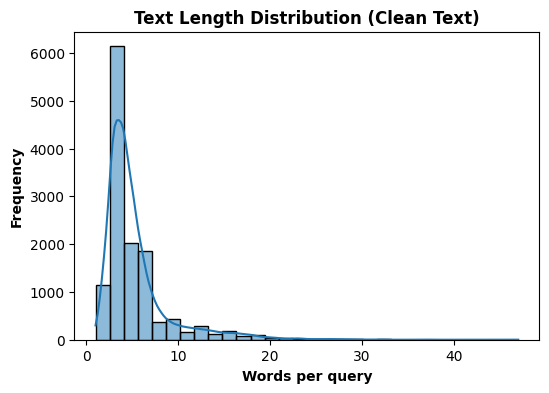

In [ ]:
# Clean Text length analysis (Full Data)
full_lengths = full_data['clean_text'].apply(lambda s: len(s.split()))
print("Full data text length stats (words):",
      "min", full_lengths.min(),
      "max", full_lengths.max(),
      "mean", round(full_lengths.mean(), 2),
      "median", int(full_lengths.median()))

plt.figure(figsize=(6,4))
sns.histplot(full_lengths, bins=30, kde=True)  # added kde for smoother curve
plt.title('Text Length Distribution (Clean Text)', fontweight="bold")
plt.xlabel('Words per query', fontweight="bold")
plt.ylabel('Frequency', fontweight="bold")
plt.show()


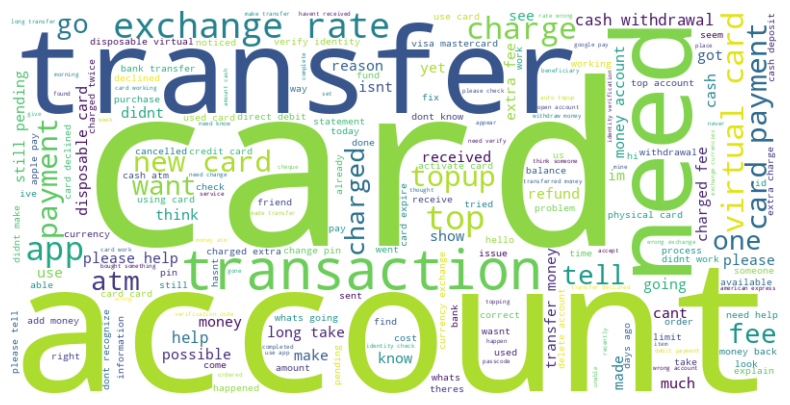

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all text into one string
all_text = " ".join(full_data['clean_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Plot
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
# Save full_data to CSV
csv_filename = "full_data_processed.csv"
full_data.to_csv(csv_filename, index=False)
print(f"✅ Full dataset saved as '{csv_filename}'")

# Download CSV to local machine
from google.colab import files
files.download(csv_filename)


✅ Full dataset saved as 'full_data_processed.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Use your existing 'split' column
#train_data = full_data[full_data['split'] == 'train'].copy()
#test_data = full_data[full_data['split'] == 'test'].copy()

In [ ]:
#Check features
print("Original dataset shape:", full_data.shape)
print("Original columns:", full_data.columns.tolist())

Original dataset shape: (13083, 11)
Original columns: ['text', 'label', 'label_text', 'split', 'category', 'urgency', 'clean_text', 'text_length', 'word_count', 'category_label', 'urgency_label']


In [ ]:
#Drop unnecessary features
features_to_drop = ['text_length', 'word_count']
full_dataset_cleaned = full_data.drop(columns=features_to_drop)
print("Remaining dataset shape:", full_dataset_cleaned.shape)
print("Remaining columns:", full_dataset_cleaned.columns.tolist())

Original dataset shape: (13083, 9)
Original columns: ['text', 'label', 'label_text', 'split', 'category', 'urgency', 'clean_text', 'category_label', 'urgency_label']


In [ ]:
# Save full_data to CSV
csv_filename = "full_dataset_cleaned.csv"
full_dataset_cleaned.to_csv(csv_filename, index=False)
print(f"✅ Full cleaned dataset saved as '{csv_filename}'")

# Download CSV to local machine
from google.colab import files
files.download(csv_filename)

✅ Full cleaned dataset saved as 'full_dataset_cleaned.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Splitting dataset as training and testing according to original split

train_data = full_dataset_cleaned[full_dataset_cleaned['split'] == 'train'].copy()
test_data = full_dataset_cleaned[full_dataset_cleaned['split'] == 'test'].copy()


In [ ]:
# Save Train dataset to CSV
csv_filename = "train_data.csv"
train_data.to_csv(csv_filename, index=False)
print(f"✅ Train dataset saved as '{csv_filename}'")

# Download CSV to local machine
from google.colab import files
files.download(csv_filename)

✅ Full cleaned dataset saved as 'train_data.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save Test dataset to CSV
csv_filename = "test_data.csv"
test_data.to_csv(csv_filename, index=False)
print(f"✅ Test dataset saved as '{csv_filename}'")

# Download CSV to local machine
from google.colab import files
files.download(csv_filename)

✅ Test dataset saved as 'test_data.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Verify split distribution
print("\nTraining data distribution:")
print("Categories:", train_data['category'].value_counts())
print("Urgency:", train_data['urgency'].value_counts())

print("\nTest data distribution:")
print("Categories:", test_data['category'].value_counts())
print("Urgency:", test_data['urgency'].value_counts())


Training data distribution:
Categories: category
Card Services          4416
Transfer & Payments    3874
Account Management     1140
General Support         573
Name: count, dtype: int64
Urgency: urgency
Low         5645
Normal      2736
Critical    1622
Name: count, dtype: int64

Test data distribution:
Categories: category
Card Services          1400
Transfer & Payments    1120
Account Management      360
General Support         200
Name: count, dtype: int64
Urgency: urgency
Low         1780
Normal       797
Critical     503
Name: count, dtype: int64


In [ ]:
# Initialize tokenizer with appropriate parameters
tokenizer = Tokenizer(
    num_words=10000,  # Vocabulary size (Keep only the 10,000 most frequent words in the dataset. Any rare word beyond that will be replaced with <OOV>)
    oov_token='<OOV>',  # Out-of-vocabulary token
    filters='!"#&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
)

# Fit tokenizer only on training data (Fit tokenizer only done fpr training dataset not for testing one to avoid data leakage)
print("Fitting tokenizer on training data...")
tokenizer.fit_on_texts(train_data['clean_text'])

Fitting tokenizer on training data...


In [ ]:
# Get vocabulary statistics
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)}")
print(f"Most common words: {list(word_index.items())[:10]}")

Vocabulary size: 2296
Most common words: [('<OOV>', 1), ('card', 2), ('account', 3), ('money', 4), ('transfer', 5), ('get', 6), ('payment', 7), ('need', 8), ('cash', 9), ('top', 10)]


In [ ]:
# Apply tokenization to ALL data (for both train and test)
print("Converting texts to sequences...")
train_sequences = tokenizer.texts_to_sequences(train_data['clean_text'])
test_sequences = tokenizer.texts_to_sequences(test_data['clean_text'])

Converting texts to sequences...


In [ ]:
# Analyze sequence lengths to determine optimal max_length
train_lengths = [len(seq) for seq in train_sequences]
print(f"\nSequence length statistics (training):")
print(f"Mean: {np.mean(train_lengths):.2f}")
print(f"Median: {np.median(train_lengths):.2f}")
print(f"95th percentile: {np.percentile(train_lengths, 95):.0f}")
print(f"Max: {np.max(train_lengths)}")


Sequence length statistics (training):
Mean: 5.42
Median: 4.00
95th percentile: 14
Max: 47


In [ ]:
# Set max_length for padding (to keeps most information while avoiding too much padding)
max_length = int(np.percentile(train_lengths, 95))
print(f"Using max_length: {max_length}")

Using max_length: 14


In [ ]:
# Apply padding to both train and test datasets

print("Applying padding...")
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

print(f"Padded training sequences shape: {train_padded.shape}")
print(f"Padded test sequences shape: {test_padded.shape}")

Applying padding...
Padded training sequences shape: (10003, 14)
Padded test sequences shape: (3080, 14)


In [ ]:
#Add tokenized and padded sequences back to dataframes
print("\n=== Adding Processed Features ===")

# Convert padded sequences to lists for CSV storage
train_data['tokenized_sequences'] = [seq.tolist() for seq in train_padded]
test_data['tokenized_sequences'] = [seq.tolist() for seq in test_padded]

# Add original sequence lengths for analysis
train_data['original_sequence_length'] = [len(seq) for seq in train_sequences]
test_data['original_sequence_length'] = [len(seq) for seq in test_sequences]

print("Added features:")
print("- tokenized_sequences: Padded integer sequences ready for neural network")
print("- original_sequence_length: Original length before padding (for analysis)")


=== Adding Processed Features ===
Added features:
- tokenized_sequences: Padded integer sequences ready for neural network
- original_sequence_length: Original length before padding (for analysis)


In [ ]:
# Save processed datasets

# Save training data
train_filename = 'banking_train_processed.csv'
train_data.to_csv(train_filename, index=False)
print(f"Training data saved as: {train_filename}")

# Download CSV to local machine
from google.colab import files
files.download(train_filename)


Training data saved as: banking_train_processed.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save test data
test_filename = 'banking_test_processed.csv'
test_data.to_csv(test_filename, index=False)
print(f"Test data saved as: {test_filename}")

# Download CSV to local machine
from google.colab import files
files.download(test_filename)


Test data saved as: banking_test_processed.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save tokenizer for later use
tokenizer_filename = 'banking_tokenizer.pkl'
with open(tokenizer_filename, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"Tokenizer saved as: {tokenizer_filename}")

# Download to local machine
from google.colab import files
files.download('banking_tokenizer.pkl')

Tokenizer saved as: banking_tokenizer.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("\n✅ All processing completed successfully! Tokenized train and test datasets and tokenizer file saved locally for further analysis")


✅ All processing completed successfully! Tokenized train and test datasets and tokenizer file saved locally for further analysis


Load the saved Training Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load preprocessed datasets
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI_CW_010/banking_train_processed.csv')
print(f"Training shape: {train_data.shape}")

Training shape: (10003, 11)


In [ ]:
def describe_training_df(df, name="train_data"):
    print(f"\n{name} overview:")
    print("Total examples:", len(df))
    print("Unique intents:", df['label_text'].nunique())
    print("Unique categories:", df['category'].nunique())
    print("Unique urgency levels:", df['urgency'].nunique())

    print("\nTop 5 intents:\n", df['label_text'].value_counts().head())
    print("\nCategory distribution:\n", df['category'].value_counts())
    print("\nUrgency distribution:\n", df['urgency'].value_counts())

    # Call it on your combined dataset
describe_training_df(train_data, "Full Dataset")


Full Dataset overview:
Total examples: 10003
Unique intents: 77
Unique categories: 4
Unique urgency levels: 3

Top 5 intents:
 label_text
card_payment_fee_charged                            187
direct_debit_payment_not_recognised                 182
balance_not_updated_after_cheque_or_cash_deposit    181
wrong_amount_of_cash_received                       180
cash_withdrawal_charge                              177
Name: count, dtype: int64

Category distribution:
 category
Card Services          4416
Transfer & Payments    3874
Account Management     1140
General Support         573
Name: count, dtype: int64

Urgency distribution:
 urgency
Low         5645
Normal      2736
Critical    1622
Name: count, dtype: int64
